# Задание 3 (манипуляции данными в Python)

<br>
Есть таблица с действиями пользователей A/B-теста (<i>task_3_events.parquet</i>):

$events$ - посещение пользователем сайта
- $user\_id$ - id юзера,
- $user\_group$ - группа A/B-теста,
- $time$ - время совершения действия,

Пользовательская сессия определяется по следующим правилам:
<br>
1. Новая сессия начинается после 30 минут бездействия.

<b>Постройте таблицу с сессиями юзеров в формате<b>:
<br>
- $user\_id$ - id юзера
- $ab\_group$ - группа A/B-теста,
- $session\_start$ - время старта сессии,
- $session\_end$ - время окончания сессии,
- $session\_date$ - дата сессии.

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import scipy
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu

In [2]:
table = pq.read_table('task_3_events.parquet')
data = table.to_pandas() 

In [3]:
events = pd.DataFrame(data)

In [4]:
events['time'] = pd.to_datetime(events['time'])

In [5]:
events.head()

,user_id,user_group,time
0,test_user_68722185,0,2023-12-01 00:00:02.465889
1,test_user_50279722,1,2023-12-01 00:00:02.490361
2,test_user_68722185,0,2023-12-01 00:00:03.803897
3,test_user_68721973,0,2023-12-01 00:00:03.821829
4,test_user_68721973,0,2023-12-01 00:00:03.854164


In [6]:
df = events.copy()

In [7]:
df = df.sort_values(by=['user_id', 'time']).reset_index(drop=True)

In [8]:
df.head()

,user_id,user_group,time
0,test_user_10021823,1,2023-12-07 01:08:51.008309
1,test_user_10021823,1,2023-12-07 01:08:53.085064
2,test_user_10021823,1,2023-12-07 01:08:56.702185
3,test_user_10021823,1,2023-12-07 01:08:57.730887
4,test_user_10021823,1,2023-12-07 01:08:57.808475


In [9]:
df['time_diff'] = df.groupby('user_id')['time'].diff().dt.total_seconds()

In [10]:
df['new_session'] = (df['time_diff'] > 30 * 60) | (df['time_diff'].isna())

In [11]:
df.rename(columns={'user_group': 'ab_group'}, inplace=True)

In [12]:
df['session_id'] = (df['new_session'].cumsum().astype(int))

In [13]:
df.head()

,user_id,ab_group,time,time_diff,new_session,session_id
0,test_user_10021823,1,2023-12-07 01:08:51.008309,NaN,True,1
1,test_user_10021823,1,2023-12-07 01:08:53.085064,2.076755,False,1
2,test_user_10021823,1,2023-12-07 01:08:56.702185,3.617121,False,1
3,test_user_10021823,1,2023-12-07 01:08:57.730887,1.028702,False,1
4,test_user_10021823,1,2023-12-07 01:08:57.808475,0.077588,False,1


In [14]:
sessions = (df.groupby(['user_id', 'ab_group', 'session_id'])
    .agg(
        session_start=('time', 'min'),
        session_end=('time', 'max'),
        session_date=('time', lambda x: x.iloc[0].date())
    )
    .reset_index()
)

In [15]:
events.head()

,user_id,user_group,time
0,test_user_68722185,0,2023-12-01 00:00:02.465889
1,test_user_50279722,1,2023-12-01 00:00:02.490361
2,test_user_68722185,0,2023-12-01 00:00:03.803897
3,test_user_68721973,0,2023-12-01 00:00:03.821829
4,test_user_68721973,0,2023-12-01 00:00:03.854164


In [16]:
sessions.head()

,user_id,ab_group,session_id,session_start,session_end,session_date
0,test_user_10021823,1,1,2023-12-07 01:08:51.008309,2023-12-07 01:10:11.804765,2023-12-07
1,test_user_10030144,0,2,2023-12-02 20:37:34.861127,2023-12-02 20:38:14.301560,2023-12-02
2,test_user_1003396,1,3,2023-12-01 00:00:48.238407,2023-12-01 00:01:41.376842,2023-12-01
3,test_user_1003396,1,4,2023-12-02 08:21:13.134305,2023-12-02 08:35:03.351138,2023-12-02
4,test_user_1003396,1,5,2023-12-02 21:12:09.512252,2023-12-02 21:34:53.437896,2023-12-02


# Задание 3 (оценка АБ-теста)

Был проведен A/B-тест.
<br>
В качестве данных используйте таблицу, построенную в предыдущем задании. Первая сессия юзера считается моментом попадания в A/B-тест.
<br><br>
Ключевая метрика эксперимента - конверсия во вторую сессию.
<br>
Сделайте вывод о том, какая группа выиграла в A/B-тесте. Ответ обоснуйте.
<br>

In [17]:
sessions.ab_group.value_counts(normalize=True)

ab_group
0    0.504632
1    0.495368
Name: proportion, dtype: float64

In [18]:
sessions.groupby('ab_group', as_index=False)['user_id'].agg(['count','nunique'])

,ab_group,count,nunique
0,0,12638,7429
1,1,12406,7399


In [19]:
sessions.isna().sum()

user_id          0
ab_group         0
session_id       0
session_start    0
session_end      0
session_date     0
dtype: int64

In [20]:
sessions['time_diff'] = sessions.groupby('user_id')['session_start'].diff().dt.total_seconds()

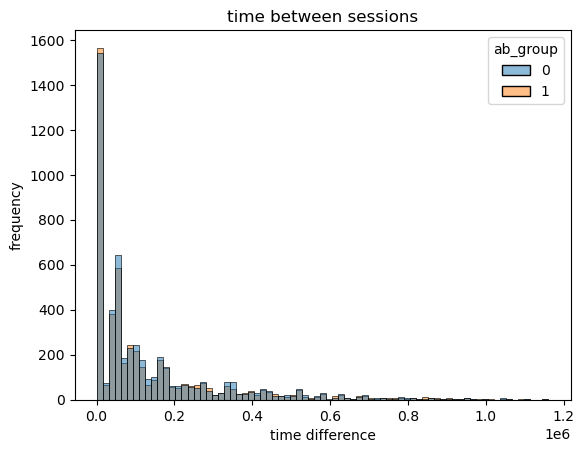

In [21]:
sns.histplot(data=sessions[sessions['session_id'] > 1],x='time_diff', hue='ab_group')

plt.title('time between sessions')
plt.xlabel('time difference')
plt.ylabel('frequency')
plt.show()

На графике видно, что **"хвост" достаточно большой**, что говорит о сильной асимметрии в данных. 
В таких случаях целесообразно использовать **Mann–Whitney U test**, так как он не требует нормальности распределения данных.

In [22]:
user_session_counts = sessions.groupby(['user_id', 'ab_group']).size().reset_index(name='session_count')

In [23]:
second_session_counts = user_session_counts[user_session_counts['session_count'] > 1] \
    .groupby('ab_group')['user_id'].nunique() \
    .reset_index(name='second_session_users')

In [24]:
group_totals = sessions.groupby('ab_group')['user_id'].nunique().reset_index(name='total_users')

In [25]:
results = group_totals.merge(second_session_counts, on='ab_group', how='left').fillna(0)
results['conversion_rate'] = results['second_session_users'] / results['total_users']

In [26]:
results

,ab_group,total_users,second_session_users,conversion_rate
0,0,7429,1833,0.246736
1,1,7399,1850,0.250034


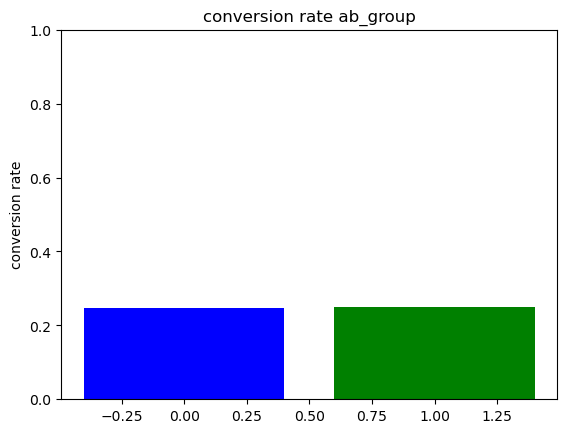

In [27]:
plt.bar(results['ab_group'], results['conversion_rate'], color=['blue', 'green'])

plt.title('conversion rate ab_group')
plt.ylabel('conversion rate')
plt.ylim(0, 1)
plt.show()

# Выводы

- **P-value > 0.05**, что указывает на **отсутствие статистически значимых различий** между группами. 
- Следовательно, проведенный эксперимент **не выявил значимого влияния изменений на ключевую метрику**.